[Build a semantic search engine](https://python.langchain.com/docs/tutorials/retrievers/)

## Credentials
Create a new Pinecone account, or sign into your existing one, and create an API key to use in this notebook.

In [1]:
import getpass
import os
import time

from pinecone import Pinecone, ServerlessSpec

d:\Anaconda\envs\medbot\lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
if not os.getenv("PINECONE_API_KEY"):
    os.environ["PINECONE_API_KEY"] = getpass.getpass("Enter your Pinecone API key: ")

pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)

## Initialization
Before initializing vector store, let's connect to a Pinecone index. If one named index_name doesn't exist, it will be created.

[LangChain Pinecone Integration](https://python.langchain.com/docs/integrations/vectorstores/pinecone/)

In [3]:
index_name = "medical-chatbot"  # change if desired

# existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,  #Needs modification according to your embedding model dimension, sentence-transformers/all-MiniLM-L6-v2 dimension is 384
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)

In [6]:
existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]
existing_indexes

['medical-chatbot']

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [5]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)

## Utility functions to `Add` items to vector store

1. Function to load custom pdf file 
    - [PyPDFDirectoryLoader](https://python.langchain.com/docs/integrations/document_loaders/pypdfdirectory/)
    - [How to load documents from a directory](https://python.langchain.com/docs/how_to/document_loader_directory/)

In [ ]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader

def load_pdf(data):
    print("Loading pdf file...")
    loader = DirectoryLoader(
        data,
        glob="*.pdf",
        loader_cls=PyPDFLoader,
        show_progress=True,
        use_multithreading=True
        )
    document = loader.load()
    print("Done.")
    return document

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable

2. Fuction to split the loaded data into `chunks`
    - [read more about Langchanin's RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)

In [52]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

#Create text chunks
def text_split(loaded_data):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 500, 
        chunk_overlap = 20,
        length_function=len)
    text_chunks = text_splitter.split_documents(loaded_data)
    return text_chunks

## Add items to vector store
We can add items to our vector store by using the add_documents function. [Click here to read more](https://python.langchain.com/docs/integrations/vectorstores/pinecone/)

In [53]:
from uuid import uuid4

extract_data = load_pdf("data/")
chunks = text_split(extract_data)
uuids = [str(uuid4()) for _ in range(len(chunks))]

vector_store.add_documents(documents=chunks, ids=uuids)

Loading pdf file...


100%|██████████| 1/1 [00:27<00:00, 27.54s/it]


Done.


KeyboardInterrupt: 

# Query vector store
Once your vector store has been created and the relevant documents have been added you will most likely wish to query it during the running of your chain or agent.


### Query directly
Performing a simple similarity search can be done as follows:

In [6]:
results = vector_store.similarity_search(
    "jaundice diagnosis"
)

print(results[0])

page_content='condition will come to the attention of a physician. If not,
the child’s abdomen will begin to swell, and the infant
will get progressively more ill. Nearly all untreated chil-
dren will die of liver failure within two years.
Diagnosis
The persistence of jaundice beyond the second week
in a newborn with clay-colored stools is a sure sign of
obstruction to the flow of bile. An immediate evaluation
that includes blood tests and imaging of the biliary sys-
tem will confirm the diagnosis.
Treatment' metadata={'page': 493.0, 'source': 'data\\Medical_book.pdf'}


In [ ]:
results = vector_store.similarity_search(
    "what is Allergy",
    k=2
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

In [6]:
prompt_template="""
Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer below and nothing else.
Helpful answer:
"""

In [7]:
from langchain_core.prompts import PromptTemplate
PROMPT=PromptTemplate(template=prompt_template, input_variables=["context", "question"])
chain_type_kwargs={"prompt": PROMPT}

In [ ]:
from langchain_community.llms import CTransformers
llm=CTransformers(model="model\\llama-2-7b-chat.ggmlv3.q4_0.bin",
                  model_type="llama",
                  config={'max_new_tokens':512,
                          'temperature':0.8})

In [10]:
from langchain.chains import RetrievalQA
retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 1, "score_threshold": 0.5},
)
qa=RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever,
    return_source_documents=True, 
    chain_type_kwargs=chain_type_kwargs
    )

In [19]:
question = "What treatments are recommended for hypertension?"
response = qa.invoke(question)

response.keys()
response['result']

'Calcium channel blocking agents (slow channel blockers or calcium antagonists) are commonly recommended to control hypertension.'

In [12]:
user_input=input(f"Input Prompt:")
result=qa.invoke({"query": user_input})
print("Response : ", result["result"])

Response :  Acne, a disease of the skin characterized by the presence of comedones (blackheads), papules, pustules, and nodules. It is caused by excess sebum, Dead white blood cells, bacteria, and other factors. Acne occurs in both men and women, usually appearing on the face, back, chest, and shoulders. Treatment options include topical and oral antibiotics, retinoids, and hormone therapy.

Please let me know if you have any questions or need further clarification.


=============================================================

d:\Anaconda\envs\medbot\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\medbot\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\medbot\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\medbot\lib\site-packages\sklearn\m

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



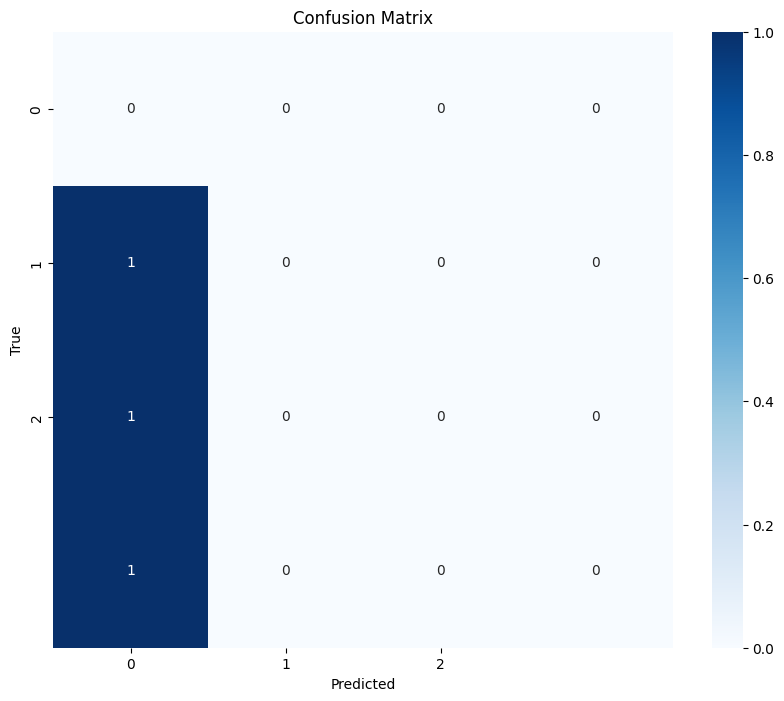

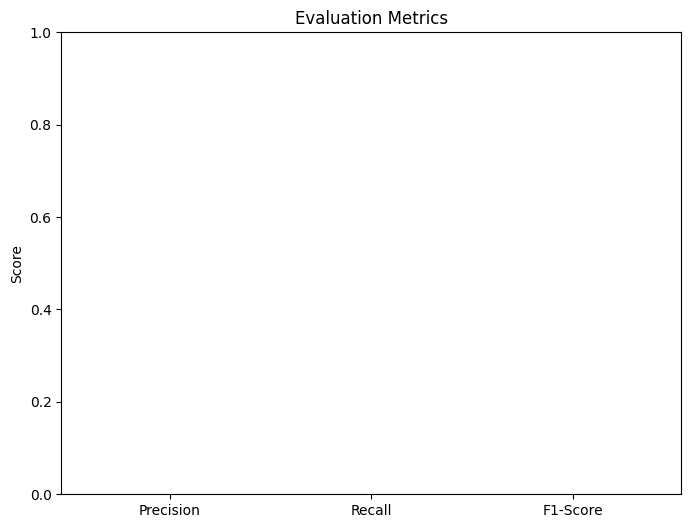

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support

# Example dataset: Add actual questions and their expected document indices
questions = ["what is allergy", "what is diabetes", "explain asthma"]
expected_indices = [0, 1, 2]  # Replace with the indices of the ground truth documents

# Perform similarity search
retrieved_indices = []
for query in questions:
    results = vector_store.similarity_search(query, k=1)  # Retrieve top 1 result
    if results:
        retrieved_indices.append(results[0].metadata.get("source_index", -1))  # Assuming you store source index in metadata
    else:
        retrieved_indices.append(-1)

# Confusion Matrix (if applicable)
true_classes = np.array(expected_indices)
predicted_classes = np.array(retrieved_indices)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(
    true_classes, predicted_classes, average="weighted", zero_division=0
)

# Classification Report
print(classification_report(true_classes, predicted_classes))

# Confusion Matrix Plot
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=expected_indices, yticklabels=expected_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Precision-Recall Bar Plot
metrics = {"Precision": precision, "Recall": recall, "F1-Score": f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color="skyblue")
plt.title("Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Generate a list of queries
queries = [
    "What are the symptoms of diabetes?",
    "Explain the treatment for asthma.",
    "What causes high blood pressure?",
    "How is cancer diagnosed?",
    "what is Allergy?",
    "Aortic aneurysm",
    "hernia symptomps",
    "jaundice diagnosis"
]

# Create a query-to-document mapping based on similarity
document_texts = [doc.page_content for doc in chunks_with_metadata]
vectorizer = TfidfVectorizer().fit(document_texts)
document_vectors = vectorizer.transform(document_texts)
query_vectors = vectorizer.transform(queries)

# Automatically find the best matching document for each query
ground_truth = {}
for idx, query in enumerate(queries):
    similarity_scores = cosine_similarity(query_vectors[idx], document_vectors)
    best_match_index = similarity_scores.argmax()
    ground_truth[query] = chunks_with_metadata[best_match_index].metadata["source_index"]

print("Generated Ground Truth:")
print(ground_truth)
